In [1]:
import sys
sys.path.append('/home/azhuravl/work')

import stereoanyvideo.datasets.video_datasets_custom as video_datasets_custom

In [ ]:
import importlib
importlib.reload(video_datasets)

In [2]:
dataset_driving = video_datasets_custom.SequenceSceneFlowDatasetCamera(
    aug_params=None,
    root="/home/azhuravl/scratch/SceneFlow",
    dstype="frames_cleanpass",
    sample_len=59,
    things_test=False,
    add_things=False,
    add_monkaa=False,
    add_driving=True,
    split="test",
    stride=5,
)
len(dataset_driving)



Added 1584 from Driving frames_cleanpass


1584

In [3]:
data_0 = dataset_driving[0]


In [ ]:
data_0['img'].shape

In [4]:
import torch

sys.path.append('/home/azhuravl/work/TrajectoryCrafter/notebooks/15_10_25_depth')

import collect_dataset

frames_tensor, depths, poses_tensor, K_tensor = collect_dataset.extract_video_data(
    data_0,
    # baseline=0.532725,
    # image_size=data_0['metadata'][0][0][1],
    )



/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [5]:
sys.path.append('/home/azhuravl/work/TrajectoryCrafter')

import models.utils as utils

warper_old = utils.Warper(device='cuda')

In [8]:
K_tensor.shape

torch.Size([59, 3, 3])

In [6]:
from tqdm import tqdm

warped_images = []
masks = []
warped_depths = []

warped_images_once = []

for i in tqdm(range(10, frames_tensor.shape[0])):
    
    transformation_1 = poses_tensor[i:i+1].clone()
    transformation_2 = poses_tensor[10:11].clone()
    
    warped_frame2, mask2, warped_depth2, flow12 = warper_old.forward_warp(
        frame1=frames_tensor[i:i+1],
        mask1=None,
        depth1=depths[i:i+1],
        transformation1=transformation_1,
        transformation2=transformation_2,
        intrinsic1=K_tensor[0].unsqueeze(0),
        intrinsic2=K_tensor[0].unsqueeze(0),
        mask=False,
        twice=True,
    )
    # depth returned is incorrect, multiply input depth by mask
    warped_depth2 = depths[i:i+1] * mask2

    warped_frame_once, _, _, _ = warper_old.forward_warp(
        frame1=frames_tensor[i:i+1],
        mask1=None,
        depth1=depths[i:i+1],
        transformation1=transformation_1,
        transformation2=transformation_2,
        intrinsic1=K_tensor[0].unsqueeze(0),
        intrinsic2=K_tensor[0].unsqueeze(0),
        mask=False,
        twice=False,
    )
    
    warped_images.append(warped_frame2)
    masks.append(mask2)
    warped_depths.append(warped_depth2)
    
    warped_images_once.append(warped_frame_once)

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:10<00:00,  4.53it/s]


(-0.5, 959.5, 539.5, -0.5)

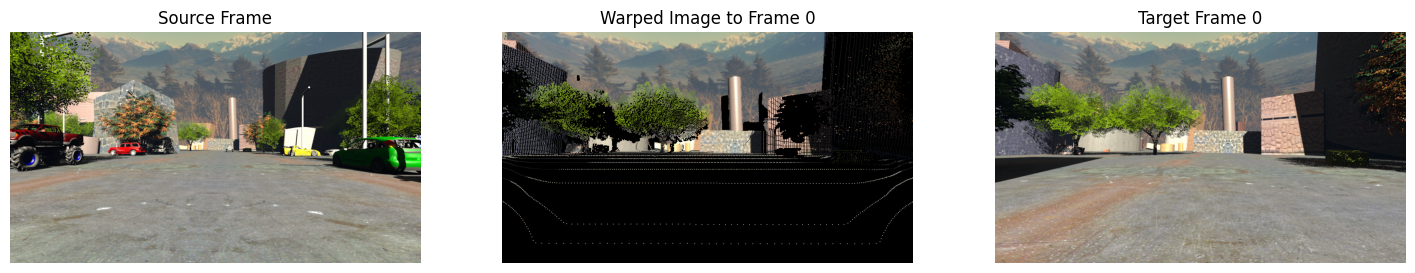

In [7]:
import matplotlib.pyplot as plt

import numpy as np

# plot warped image j, mask j, warped depth j
j = 0
k = 30

frame = frames_tensor[j+10].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
warped_image = warped_images[k][0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
target_frame = frames_tensor[k+10].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(frame)
plt.title('Source Frame')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(warped_image)
plt.title('Warped Image to Frame {}'.format(j))
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(target_frame)
plt.title('Target Frame {}'.format(j))
plt.axis('off')


## Resize and Save

In [8]:
import torch
import torch.nn.functional as F


def get_resize_strategy(original_height, original_width, target_height=384, target_width=672):
    """Determine the best resize strategy based on aspect ratios"""
    original_aspect = original_width / original_height
    target_aspect = target_width / target_height  # 672/384 = 1.75
    
    if original_aspect > target_aspect * 1.2:
        return "crop_width"
    # If original is much taller, crop height  
    elif original_aspect < target_aspect * 0.8:
        return "crop_height"
    else:
        # For remaining cases, just use resize (may cause some distortion)
        return "resize"


def smart_video_resize(video, target_height=384, target_width=672, interpolation_mode='bilinear'):
    """
    Smart resize for videos with various aspect ratios
    
    Args:
        video: tensor of shape [T, C, H, W]
        target_height: target height (default 384)
        target_width: target width (default 672)
        interpolation_mode: 'bilinear' for RGB videos, 'nearest' for masks
        
    Returns:
        video: tensor of shape [T, C, target_height, target_width]
    """
    T, C, H, W = video.shape
    
    strategy = get_resize_strategy(H, W, target_height, target_width)
    
    print(f"resize strategy: '{strategy}' for original size ({H}, {W}), aspect ratio {W/H:.2f}, target ratio {target_width/target_height:.2f}")
    
    if strategy == "resize":
        # Simple resize when aspect ratios are similar or as fallback
        video = F.interpolate(
            video, 
            size=(target_height, target_width), 
            mode=interpolation_mode, 
            align_corners=False if interpolation_mode == 'bilinear' else None
        )
        
    elif strategy == "crop_width":
        # Video is too wide - crop width first, then resize
        target_aspect = target_width / target_height
        new_width = int(H * target_aspect)
        
        # Center crop width
        start_w = (W - new_width) // 2
        video = video[:, :, :, start_w:start_w + new_width]
        
        # Then resize to target
        video = F.interpolate(
            video,
            size=(target_height, target_width),
            mode=interpolation_mode,
            align_corners=False if interpolation_mode == 'bilinear' else None
        )
        
    elif strategy == "crop_height":
        # Video is too tall - crop height first, then resize
        target_aspect = target_width / target_height
        new_height = int(W / target_aspect)
        
        # Center crop height
        start_h = (H - new_height) // 2
        video = video[:, :, start_h:start_h + new_height, :]
        
        # Then resize to target
        video = F.interpolate(
            video,
            size=(target_height, target_width),
            mode=interpolation_mode,
            align_corners=False if interpolation_mode == 'bilinear' else None
        )
    
    return video

In [9]:
from models.utils import save_video
import os
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np


def make_dimensions_even(tensor):
    """Pad tensor to make height and width even numbers"""
    _, h, w, c = tensor.shape
    pad_h = h % 2
    pad_w = w % 2
    
    if pad_h > 0 or pad_w > 0:
        # Pad bottom and right if needed
        tensor = torch.nn.functional.pad(tensor, (0, 0, 0, pad_w, 0, pad_h))
    
    return tensor


def apply_colormap_to_depth(depth_tensor, colormap='viridis', inverse=True):
    """Apply colormap to depth tensor for better visualization"""
    # Create mask for zero values
    zero_mask = (depth_tensor == 0)
    
    if inverse:
        # Compute inverse depth, avoid division by zero
        depth_processed = torch.where(depth_tensor > 0, 1.0 / depth_tensor, torch.zeros_like(depth_tensor))
    else:
        depth_processed = depth_tensor
    
    # Normalize non-zero values to [0, 1]
    if depth_processed[~zero_mask].numel() > 0:
        depth_norm = depth_processed / depth_processed[~zero_mask].max()
    else:
        depth_norm = depth_processed
    
    # Convert to numpy and apply colormap
    depth_np = depth_norm.cpu().numpy()
    colormap_func = matplotlib.colormaps.get_cmap(colormap)
    depth_colored = colormap_func(depth_np)  # Returns RGBA
    
    # Convert back to tensor, drop alpha channel
    depth_colored_tensor = torch.from_numpy(depth_colored[..., :3]).to(depth_tensor.device)
    
    # Set zero depth areas to black
    zero_mask_expanded = zero_mask.unsqueeze(-1).expand_as(depth_colored_tensor)
    depth_colored_tensor[zero_mask_expanded] = 0.0  # Black for zero depth
    
    return depth_colored_tensor



save_dir = '/home/azhuravl/work/TrajectoryCrafter/notebooks/22_10_25_scaling_up/driving_resized'
os.makedirs(save_dir, exist_ok=True)


### Save videos

# for saving: [T, H, W, C] in [0,1]
# for diffusion: [C, T, H, W] in [0,1]


# input and ref videos
frames_tensor_resized = (frames_tensor + 1.0) / 2.0  # [T, 3, H, W] in [0,1]
frames_tensor_resized = smart_video_resize(frames_tensor_resized)
save_video(
    frames_tensor_resized[10:].permute(0, 2, 3, 1),
    f'{save_dir}/input_video.mp4',
    fps=10,
)
save_video(
    frames_tensor_resized[:10].permute(0, 2, 3, 1),
    f'{save_dir}/ref_video.mp4',
    fps=10,
)

# masks
masks_tensor = torch.cat(masks)
masks_tensor_resized = smart_video_resize(masks_tensor, interpolation_mode='nearest')
save_video(
    masks_tensor_resized.permute(0, 2, 3, 1).repeat(1, 1, 1, 3),
    f'{save_dir}/masks.mp4',
    fps=10,
)

# twice warped video
# cond_video_twice = (torch.cat(warped_images) + 1.0) / 2.0  # [T, 3, H, W] in [0,1]
# cond_video_twice_resized = smart_video_resize(
#     cond_video_twice,
#     interpolation_mode='nearest'
#     )
cond_video_twice_resized = frames_tensor_resized[10:] * masks_tensor_resized
save_video(
    cond_video_twice_resized.permute(0, 2, 3, 1),
    f'{save_dir}/warped_video_twice.mp4',
    fps=10,
)

# once warped
cond_video_once = (torch.cat(warped_images_once) + 1.0) / 2.0  # [T, 3, H, W] in [0,1]
cond_video_once_resized = smart_video_resize(
    cond_video_once,
    interpolation_mode='nearest'
)
save_video(
    cond_video_once_resized.permute(0, 2, 3, 1),
    f'{save_dir}/warped_video_once.mp4',
    fps=10,
)


### Save depths

# input and ref depths
depths_resized = smart_video_resize(depths)
depths_colored = apply_colormap_to_depth(depths_resized.squeeze(1), inverse=True)
save_video(
    depths_colored[10:],
    f'{save_dir}/input_depths.mp4',
    fps=10,
)
save_video(
    depths_colored[:10],
    f'{save_dir}/ref_depths.mp4',
    fps=10,
)


# warped depths
# warped_depths_tensor = torch.cat(warped_depths)
# warped_depths_tensor_resized = smart_video_resize(
#     warped_depths_tensor,
#     interpolation_mode='nearest'
# )
warped_depths_tensor_resized = depths_resized[10:] * masks_tensor_resized
warped_depths_colored = apply_colormap_to_depth(warped_depths_tensor_resized.squeeze(1), inverse=True)
save_video(
    warped_depths_colored,
    f'{save_dir}/warped_depths.mp4',
    fps=10,
)


resize strategy: 'resize' for original size (540, 960), aspect ratio 1.78, target ratio 1.75
resize strategy: 'resize' for original size (540, 960), aspect ratio 1.78, target ratio 1.75
resize strategy: 'resize' for original size (540, 960), aspect ratio 1.78, target ratio 1.75
resize strategy: 'resize' for original size (540, 960), aspect ratio 1.78, target ratio 1.75


In [ ]:
depths_colored.shape

In [ ]:
import torch, json

# extrinsics
with open(f"{save_dir}/extrinsics.json", "w") as f:
    json.dump(poses_tensor.cpu().tolist(), f, indent=2)

# intrinsics
with open(f"{save_dir}/intrinsics.json", "w") as f:
    json.dump(K_tensor[0].cpu().tolist(), f, indent=2)


In [13]:
import numpy as np

frames_np = ((frames_tensor.cpu().permute(0, 2, 3, 1).numpy() + 1.0) / 2.0).astype(np.float32)

caption = trajcrafter.get_caption(opts, frames_np[opts.video_length // 2])
with open(f"{save_dir}/caption.txt", "w") as f:
    f.write(caption)
print("Caption:", caption)

Caption: a car is parked in the middle of a street. The video is of high quality, and the view is very clear. High quality, masterpiece, best quality, highres, ultra-detailed, fantastic.


In [ ]:
depths.min(), depths.max(), warped_depths_tensor.min(), warped_depths_tensor.max()

## Save:

### 1,000 for visualization
- 49 input RGB + 10 ref
- 49 warped RGB 2x
- 49 warped RGB 1x
- 49 input depth + 10 ref
- 49 warped depth
- 49 masks
- caption
- camera extr
- camera intr


### 10,000 for training
- 49 GT RGB latents
- 10 ref latents
- 49 warped RGB 2x latents
- 49 masks
- caption latents

- 49 GT depth latents
- 10 ref depth latents
- 49 warped depth latents


### TODO
- ++ implement saving for visualization, 1 subdir per sample
- ++ crop or interpolate videos to fixed size
- ++ rename resized variables
- encode training data to latents
- check them by running inference
- implement saving for training, to a tar directly

In [14]:
import torch
import torch.nn.functional as F
from einops import rearrange

def encode_inputs_to_latents(
    pipeline,
    video=None,
    reference=None,
    mask_video=None,
    masked_video_latents=None,
    prompt=None,
    negative_prompt=None,
    height=480,
    width=720,
    device="cuda",
    batch_size=1,
    noise_aug_strength=0.0563,
    max_sequence_length=226,
    do_classifier_free_guidance=True,
    # New parameters for training
    ground_truth_video=None,  # GT video for training
    encode_for_training=False  # Flag to indicate training vs inference
):
    """
    Encode all inputs (video, reference, mask, prompts) to latents for training dataset preparation.
    
    Args:
        video: Conditioning video (warped/masked video for inference)
        ground_truth_video: Ground truth video for training targets
        encode_for_training: If True, encodes GT video as training targets
    """
    
    results = {}
    
    with torch.no_grad():
        # 1. Encode text prompts (same for both training and inference)
        if prompt is not None:
            prompt_embeds, negative_prompt_embeds = pipeline.encode_prompt(
                prompt=prompt,
                negative_prompt=negative_prompt,
                do_classifier_free_guidance=do_classifier_free_guidance,
                num_videos_per_prompt=1,
                prompt_embeds=None,
                negative_prompt_embeds=None,
                max_sequence_length=max_sequence_length,
                device=device,
            )
            
            results['prompt_embeds'] = prompt_embeds.cpu()
            if negative_prompt_embeds is not None:
                results['negative_prompt_embeds'] = negative_prompt_embeds.cpu()
        
        # 2. Process reference video (same for both training and inference)
        if reference is not None:
            ref_length = reference.shape[2]
            ref_video = pipeline.image_processor.preprocess(
                rearrange(reference, "b c f h w -> (b f) c h w"), 
                height=height, 
                width=width
            )
            ref_video = rearrange(ref_video, "(b f) c h w -> b c f h w", f=ref_length)
            ref_video = ref_video.to(device=device, dtype=pipeline.vae.dtype)
            
            # Encode reference video
            bs = 1
            new_ref_video = []
            for i in range(0, ref_video.shape[0], bs):
                video_bs = ref_video[i : i + bs]
                video_bs = pipeline.vae.encode(video_bs)[0]
                video_bs = video_bs.sample()
                new_ref_video.append(video_bs)
            new_ref_video = torch.cat(new_ref_video, dim=0)
            new_ref_video = new_ref_video * pipeline.vae.config.scaling_factor
            ref_latents = new_ref_video.repeat(batch_size // new_ref_video.shape[0], 1, 1, 1, 1)
            
            # Rearrange ONLY for final storage
            ref_latents_final = rearrange(ref_latents, "b c f h w -> b f c h w")
            results['ref_latents'] = ref_latents_final.cpu()
        
        # 3. Encode ground truth video for training targets
        if encode_for_training and ground_truth_video is not None:
            gt_video_length = ground_truth_video.shape[2]
            gt_processed = pipeline.image_processor.preprocess(
                rearrange(ground_truth_video, "b c f h w -> (b f) c h w"), 
                height=height, 
                width=width
            )
            gt_processed = rearrange(gt_processed, "(b f) c h w -> b c f h w", f=gt_video_length)
            gt_processed = gt_processed.to(device=device, dtype=pipeline.vae.dtype)
            
            # Encode ground truth video
            bs = 1
            new_gt_video = []
            for i in range(0, gt_processed.shape[0], bs):
                video_bs = gt_processed[i : i + bs]
                video_bs = pipeline.vae.encode(video_bs)[0]
                video_bs = video_bs.sample()
                new_gt_video.append(video_bs)
            gt_encoded = torch.cat(new_gt_video, dim=0)
            gt_encoded = gt_encoded * pipeline.vae.config.scaling_factor
            
            # Store GT latents for training (in transformer format)
            gt_latents_final = rearrange(gt_encoded, "b c f h w -> b f c h w")
            results['gt_video_latents'] = gt_latents_final.cpu()
        
        # 4. Process conditioning video (if provided)
        init_video = None
        video_latents_bcfhw = None  # Keep in original format for mask processing
        
        if video is not None:
            video_length = video.shape[2]
            init_video = pipeline.image_processor.preprocess(
                rearrange(video, "b c f h w -> (b f) c h w"), 
                height=height, 
                width=width
            )
            init_video = init_video.to(dtype=torch.float32)
            init_video = rearrange(init_video, "(b f) c h w -> b c f h w", f=video_length)
            init_video = init_video.to(device=device, dtype=pipeline.vae.dtype)
            
            # Encode conditioning video
            bs = 1
            new_video = []
            for i in range(0, init_video.shape[0], bs):
                video_bs = init_video[i : i + bs]
                video_bs = pipeline.vae.encode(video_bs)[0]
                video_bs = video_bs.sample()
                new_video.append(video_bs)
            video_encoded = torch.cat(new_video, dim=0)
            video_encoded = video_encoded * pipeline.vae.config.scaling_factor
            
            # Keep in [b, c, f, h, w] format for mask processing
            video_latents_bcfhw = video_encoded
            
            # Rearrange ONLY for final storage
            video_latents_final = rearrange(video_encoded, "b c f h w -> b f c h w")
            results['cond_video_latents'] = video_latents_final.cpu()  # Renamed for clarity
        
        # 5. Get model configuration
        num_channels_transformer = pipeline.transformer.config.in_channels
        num_channels_latents = pipeline.vae.config.latent_channels
        
        # 6. Process mask video (same as before but use video_latents_bcfhw or gt if available)
        reference_latents_bcfhw = video_latents_bcfhw
        if encode_for_training and ground_truth_video is not None:
            # For training, use GT video shape as reference
            reference_latents_bcfhw = rearrange(gt_encoded, "b f c h w -> b c f h w")
        
        if mask_video is not None and reference_latents_bcfhw is not None:
            video_length = mask_video.shape[2]
            
            if (mask_video == 255).all():
                # All mask case
                mask_latents = torch.zeros_like(reference_latents_bcfhw)[:, :, :1]
                masked_video_latents = torch.zeros_like(reference_latents_bcfhw)
                
                results['mask_latents'] = rearrange(mask_latents, "b c f h w -> b f c h w").cpu()
                results['masked_video_latents'] = rearrange(masked_video_latents, "b c f h w -> b f c h w").cpu()
                results['mask'] = None
            else:
                # Process mask condition
                mask_condition = pipeline.mask_processor.preprocess(
                    rearrange(mask_video, "b c f h w -> (b f) c h w"),
                    height=height,
                    width=width,
                )
                mask_condition = mask_condition.to(dtype=torch.float32)
                mask_condition = rearrange(mask_condition, "(b f) c h w -> b c f h w", f=video_length)
                
                if num_channels_transformer != num_channels_latents:
                    # Inpainting model case
                    mask_condition_tile = torch.tile(mask_condition, [1, 3, 1, 1, 1])
                    
                    # Create masked video (use init_video as base)
                    if masked_video_latents is None and init_video is not None:
                        masked_video = init_video  # Use the conditioning video
                    else:
                        masked_video = masked_video_latents or init_video
                    
                    # Encode masked video using prepare_mask_latents
                    _, masked_video_latents = pipeline.prepare_mask_latents(
                        None,
                        masked_video,
                        batch_size,
                        height,
                        width,
                        pipeline.vae.dtype,
                        device,
                        None,  # generator
                        do_classifier_free_guidance=False,
                        noise_aug_strength=noise_aug_strength,
                    )
                    
                    # Resize mask to latent size
                    mask_latents = resize_mask(1 - mask_condition, masked_video_latents)
                    mask_latents = mask_latents * pipeline.vae.config.scaling_factor
                    
                    # FIX: Ensure mask_latents matches the dtype of other latents
                    mask_latents = mask_latents.to(dtype=masked_video_latents.dtype)

                    
                    # Create mask at latent resolution
                    mask = torch.tile(mask_condition, [1, num_channels_latents, 1, 1, 1])
                    mask = F.interpolate(
                        mask,
                        size=reference_latents_bcfhw.size()[-3:],
                        mode='trilinear', 
                        align_corners=True
                    )
                    
                    # FIX: Ensure mask matches the dtype of other latents  
                    mask = mask.to(dtype=reference_latents_bcfhw.dtype)

                    
                    # Rearrange for final storage
                    mask_input = rearrange(mask_latents, "b c f h w -> b f c h w")
                    masked_video_latents_input = rearrange(masked_video_latents, "b c f h w -> b f c h w")
                    mask_final = rearrange(mask, "b c f h w -> b f c h w")
                    
                    results['mask_latents'] = mask_input.cpu()
                    results['masked_video_latents'] = masked_video_latents_input.cpu()
                    results['mask'] = mask_final.cpu()
                else:
                    # Non-inpainting model case
                    mask = torch.tile(mask_condition, [1, num_channels_latents, 1, 1, 1])
                    mask = F.interpolate(
                        mask,
                        size=reference_latents_bcfhw.size()[-3:],
                        mode='trilinear',
                        align_corners=True
                    )
                    mask_final = rearrange(mask, "b c f h w -> b f c h w")
                    results['mask'] = mask_final.cpu()
                    results['mask_latents'] = None
                    results['masked_video_latents'] = None
    
    return results


def resize_mask(mask, latent, process_first_frame_only=True):
    """Helper function from the pipeline - resize mask to match latent dimensions"""
    latent_size = latent.size()
    batch_size, channels, num_frames, height, width = mask.shape

    if process_first_frame_only:
        target_size = list(latent_size[2:])
        target_size[0] = 1
        first_frame_resized = F.interpolate(
            mask[:, :, 0:1, :, :],
            size=target_size,
            mode='trilinear',
            align_corners=False,
        )

        target_size = list(latent_size[2:])
        target_size[0] = target_size[0] - 1
        if target_size[0] != 0:
            remaining_frames_resized = F.interpolate(
                mask[:, :, 1:, :, :],
                size=target_size,
                mode='trilinear',
                align_corners=False,
            )
            resized_mask = torch.cat(
                [first_frame_resized, remaining_frames_resized], dim=2
            )
        else:
            resized_mask = first_frame_resized
    else:
        target_size = list(latent_size[2:])
        resized_mask = F.interpolate(
            mask, size=target_size, mode='trilinear', align_corners=False
        )
    return resized_mask


def prepare_encoded_inputs_for_inference(encoded_data, do_classifier_free_guidance=True):
    """
    Helper function to prepare pre-encoded inputs for inference.
    """
    prepared_inputs = {}
    
    # Prepare prompt embeddings with CFG
    if 'prompt_embeds' in encoded_data:
        prompt_embeds = encoded_data['prompt_embeds']
        if do_classifier_free_guidance and 'negative_prompt_embeds' in encoded_data:
            negative_prompt_embeds = encoded_data['negative_prompt_embeds']
            # Concatenate for CFG as done in the pipeline
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
        prepared_inputs['prompt_embeds'] = prompt_embeds
    
    # Prepare reference latents with CFG
    if 'ref_latents' in encoded_data:
        ref_latents = encoded_data['ref_latents']
        if do_classifier_free_guidance:
            ref_input = torch.cat([ref_latents] * 2)
        else:
            ref_input = ref_latents
        prepared_inputs['ref_input'] = ref_input
    
    # Prepare inpaint latents with CFG
    if 'mask_latents' in encoded_data and 'masked_video_latents' in encoded_data:
        mask_latents = encoded_data['mask_latents']
        masked_video_latents = encoded_data['masked_video_latents']
        
        if mask_latents is not None and masked_video_latents is not None:
            if do_classifier_free_guidance:
                mask_input = torch.cat([mask_latents] * 2)
                masked_video_latents_input = torch.cat([masked_video_latents] * 2)
            else:
                mask_input = mask_latents
                masked_video_latents_input = masked_video_latents
            
            # Channel concatenation for inpainting
            inpaint_latents = torch.cat([mask_input, masked_video_latents_input], dim=2)
            prepared_inputs['inpaint_latents'] = inpaint_latents
    
    # Load other encoded inputs
    for key in ['video_latents', 'mask']:
        if key in encoded_data and encoded_data[key] is not None:
            prepared_inputs[key] = encoded_data[key]
    
    return prepared_inputs

In [22]:
[torch.tensor([1, 2])] * 2

[tensor([1, 2]), tensor([1, 2])]

In [18]:
masks_tensor_resized.shape

torch.Size([49, 1, 384, 672])

In [19]:
frames_tensor_resized.shape, cond_video_twice_resized.shape, masks_tensor_resized.shape

(torch.Size([59, 3, 384, 672]),
 torch.Size([49, 3, 384, 672]),
 torch.Size([49, 1, 384, 672]))

In [20]:
latents_dict['video_latents'].size()

NameError: name 'latents_dict' is not defined

In [16]:
mask_video = (1.0 - masks_tensor_resized.permute(1, 0, 2, 3).unsqueeze(0)) * 255.0


latents_dict = encode_inputs_to_latents(
    trajcrafter.pipeline,
    video=cond_video_twice_resized.permute(1, 0, 2, 3).unsqueeze(0).to('cuda'),
    reference=frames_tensor_resized[:10].permute(1, 0, 2, 3).unsqueeze(0).to('cuda'),
    mask_video=mask_video.to('cuda'),
    masked_video_latents=None,
    prompt=caption,
    negative_prompt=opts.negative_prompt,
    height=384,
    width=672,
    device="cuda",
    batch_size=1,
    noise_aug_strength=0.0563,
    max_sequence_length=226,
    do_classifier_free_guidance=True,
    ground_truth_video=frames_tensor_resized[10:].permute(1, 0, 2, 3).unsqueeze(0).to('cuda'),  # GT video for training
    encode_for_training=True  # Flag to indicate training vs inference
)

In [22]:
# for each key, print shape

save_dir_latents = '/home/azhuravl/work/TrajectoryCrafter/notebooks/22_10_25_scaling_up/latents'
for key, value in latents_dict.items():
    if isinstance(value, torch.Tensor):
        print(f"{key}: {value.shape}, dtype={value.dtype}")
        
        # save it to disk as .pt file
        # torch.save(value, f"{save_dir_latents}/{key}.pt")
    else:
        print(f"{key}: {value}")

prompt_embeds: torch.Size([1, 226, 4096]), dtype=torch.bfloat16
negative_prompt_embeds: torch.Size([1, 226, 4096]), dtype=torch.bfloat16
ref_latents: torch.Size([1, 3, 16, 48, 84]), dtype=torch.bfloat16
gt_video_latents: torch.Size([1, 13, 16, 48, 84]), dtype=torch.bfloat16
cond_video_latents: torch.Size([1, 13, 16, 48, 84]), dtype=torch.bfloat16
mask_latents: torch.Size([1, 13, 1, 48, 84]), dtype=torch.bfloat16
masked_video_latents: torch.Size([1, 13, 16, 48, 84]), dtype=torch.bfloat16
mask: torch.Size([1, 16, 16, 48, 84]), dtype=torch.bfloat16


In [ ]:
# save video_latents as pt to /home/azhuravl/work/TrajectoryCrafter/notebooks/22_10_25_scaling_up/latents
torch.save(
    latents_dict['video_latents'],
    '/home/azhuravl/work/TrajectoryCrafter/notebooks/22_10_25_scaling_up/latents/video_latents.pt'
)

In [20]:
for i in range(10):
    torch.save(
        latents_dict,
        f'/home/azhuravl/scratch/dataset_latents/latents_{i:05d}.pt'
    )

In [18]:
latents_dict_loaded = torch.load(
    '/home/azhuravl/work/TrajectoryCrafter/notebooks/22_10_25_scaling_up/latents/latents_dict.pt',
    weights_only=True
)

In [19]:
latents_dict_loaded.keys()

dict_keys(['prompt_embeds', 'negative_prompt_embeds', 'ref_latents', 'gt_video_latents', 'cond_video_latents', 'mask_latents', 'masked_video_latents', 'mask'])

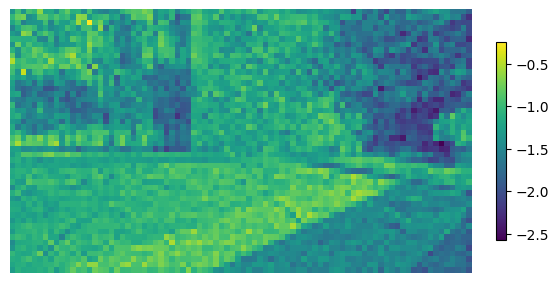

In [33]:
plt.imshow(
    latents_dict['gt_video_latents'][0,12,10].cpu().float(),
    cmap='viridis'
)
plt.axis('off')
plt.colorbar(fraction=0.02)

## Run inference with latents

In [ ]:
from diffusers.utils.torch_utils import randn_tensor
import time

def run_inference_from_cached_latents(
    pipeline,
    cached_latents,
    height=480,
    width=720,
    num_frames=49,
    num_inference_steps=50,
    guidance_scale=6.0,
    use_dynamic_cfg=False,
    eta=0.0,
    generator=None,
    latents=None,
    output_type="numpy",
    return_dict=False,
    strength=1.0,
    noise_aug_strength=0.0563,
    device="cuda"
):
    """
    Run TrajectoryCrafter inference using pre-encoded cached latents.
    Uses only conditioning inputs, NOT ground truth latents.
    """
    start_time = time.time()
    
    # Move cached latents to device
    for key, value in cached_latents.items():
        if isinstance(value, torch.Tensor):
            cached_latents[key] = value.to(device)
    
    # Setup basic parameters
    batch_size = 1
    num_videos_per_prompt = 1
    do_classifier_free_guidance = guidance_scale > 1.0
    
    pipeline._guidance_scale = guidance_scale
    pipeline._interrupt = False
    
    # 1. Prepare prompt embeddings (from cache)
    if 'prompt_embeds' in cached_latents:
        prompt_embeds = cached_latents['prompt_embeds']
        if do_classifier_free_guidance and 'negative_prompt_embeds' in cached_latents:
            negative_prompt_embeds = cached_latents['negative_prompt_embeds']
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
    else:
        raise ValueError("prompt_embeds not found in cached_latents")
    
    # 2. Set timesteps
    pipeline.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps, num_inference_steps = pipeline.get_timesteps(
        num_inference_steps=num_inference_steps, 
        strength=strength, 
        device=device
    )
    pipeline._num_timesteps = len(timesteps)
    
    latent_timestep = timesteps[:1].repeat(batch_size * num_videos_per_prompt)
    is_strength_max = strength == 1.0
    
    # 3. Prepare reference latents (from cache)
    if 'ref_latents' in cached_latents:
        ref_latents = cached_latents['ref_latents']
        ref_input = torch.cat([ref_latents] * 2) if do_classifier_free_guidance else ref_latents
    else:
        raise ValueError("ref_latents not found in cached_latents")
    
    # 4. Prepare initial latents for denoising
    num_channels_latents = pipeline.vae.config.latent_channels
    num_channels_transformer = pipeline.transformer.config.in_channels
    
    # For img2vid, use conditioning video latents if available (NOT gt_video_latents!)
    init_video_latents = None
    if 'cond_video_latents' in cached_latents:
        # Use conditioning video latents for img2vid initialization
        cond_latents = cached_latents['cond_video_latents']  # [b, f, c, h, w]
        init_video_latents = rearrange(cond_latents, "b f c h w -> b c f h w")
    
    # Prepare latents shape
    shape = (
        batch_size,
        (num_frames - 1) // pipeline.vae_scale_factor_temporal + 1,
        num_channels_latents,
        height // pipeline.vae_scale_factor_spatial,
        width // pipeline.vae_scale_factor_spatial,
    )
    
    if latents is None:
        noise = randn_tensor(shape, generator=generator, device=device, dtype=prompt_embeds.dtype)
        if init_video_latents is not None and not is_strength_max:
            # Convert to transformer format for noise addition
            video_latents = rearrange(init_video_latents, "b c f h w -> b f c h w")
            latents = pipeline.scheduler.add_noise(video_latents, noise, latent_timestep)
        else:
            # Pure text2video generation - start from pure noise
            latents = noise
        latents = latents * pipeline.scheduler.init_noise_sigma if is_strength_max else latents
    else:
        noise = latents.to(device)
        latents = noise * pipeline.scheduler.init_noise_sigma
    
    # 5. Prepare inpainting latents (from cache)
    inpaint_latents = None
    mask = None
    
    if num_channels_transformer != num_channels_latents:
        # Inpainting model - need mask_latents and masked_video_latents
        if 'mask_latents' in cached_latents and 'masked_video_latents' in cached_latents:
            mask_latents = cached_latents['mask_latents']
            masked_video_latents = cached_latents['masked_video_latents']
            
            if mask_latents is not None and masked_video_latents is not None:
                mask_input = torch.cat([mask_latents] * 2) if do_classifier_free_guidance else mask_latents
                masked_video_latents_input = torch.cat([masked_video_latents] * 2) if do_classifier_free_guidance else masked_video_latents
                
                # Channel concatenation for inpainting
                inpaint_latents = torch.cat([mask_input, masked_video_latents_input], dim=2)
        
        # Also get the mask if available
        if 'mask' in cached_latents and cached_latents['mask'] is not None:
            mask = cached_latents['mask']
    else:
        # Non-inpainting model - just need mask
        if 'mask' in cached_latents and cached_latents['mask'] is not None:
            mask = cached_latents['mask']
        else:
            # Create zero mask if none provided
            mask = torch.zeros_like(latents)
    
    # 6. Prepare extra step kwargs
    extra_step_kwargs = pipeline.prepare_extra_step_kwargs(generator, eta)
    
    # 7. Create rotary embeddings if required
    image_rotary_emb = (
        pipeline._prepare_rotary_positional_embeddings(height, width, latents.size(1), device)
        if pipeline.transformer.config.use_rotary_positional_embeddings
        else None
    )
    
    # 8. Denoising loop
    num_warmup_steps = max(len(timesteps) - num_inference_steps * pipeline.scheduler.order, 0)
    
    with pipeline.progress_bar(total=num_inference_steps) as progress_bar:
        old_pred_original_sample = None
        for i, t in enumerate(timesteps):
            if pipeline.interrupt:
                continue
                
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = pipeline.scheduler.scale_model_input(latent_model_input, t)
            
            timestep = t.expand(latent_model_input.shape[0])
            
            # Predict noise
            noise_pred = pipeline.transformer(
                hidden_states=latent_model_input,
                encoder_hidden_states=prompt_embeds,
                timestep=timestep,
                image_rotary_emb=image_rotary_emb,
                return_dict=False,
                inpaint_latents=inpaint_latents,
                cross_latents=ref_input,
            )[0]
            noise_pred = noise_pred.float()
            
            # Apply guidance
            if use_dynamic_cfg:
                import math
                pipeline._guidance_scale = 1 + guidance_scale * (
                    (1 - math.cos(math.pi * ((num_inference_steps - t.item()) / num_inference_steps) ** 5.0)) / 2
                )
            
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + pipeline.guidance_scale * (noise_pred_text - noise_pred_uncond)
            
            # Compute previous sample
            if not hasattr(pipeline.scheduler, 'step') or 'DPM' not in pipeline.scheduler.__class__.__name__:
                latents = pipeline.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
            else:
                latents, old_pred_original_sample = pipeline.scheduler.step(
                    noise_pred, old_pred_original_sample, t,
                    timesteps[i - 1] if i > 0 else None, latents,
                    **extra_step_kwargs, return_dict=False,
                )
            
            latents = latents.to(prompt_embeds.dtype)
            
            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipeline.scheduler.order == 0):
                progress_bar.update()
    
    # 9. Decode latents
    if output_type == "numpy":
        video = pipeline.decode_latents(latents)
    elif output_type != "latent":
        video = pipeline.decode_latents(latents)
        video = pipeline.video_processor.postprocess_video(video=video, output_type=output_type)
    else:
        video = latents
    
    # Clean up
    pipeline.maybe_free_model_hooks()
    
    return video
    
    # if not return_dict:
    #     if output_type == "numpy":
    #         video = torch.from_numpy(video)
    
    # return CogVideoX_Fun_PipelineOutput(videos=video)

In [ ]:
!nvidia-smi

In [ ]:
generator = torch.Generator(device=opts.device).manual_seed(opts.seed)

with torch.no_grad():
    output = run_inference_from_cached_latents(
        trajcrafter.pipeline,
        latents_dict,
        height=opts.sample_size[0],
        width=opts.sample_size[1],
        num_frames=opts.video_length,
        guidance_scale=opts.diffusion_guidance_scale,
        num_inference_steps=opts.diffusion_inference_steps,
        generator=generator,
        device=torch.device("cuda")
    )

In [ ]:
output = torch.from_numpy(output)

In [ ]:
output.shape

In [ ]:
# frames_tensor_resized = (frames_tensor + 1.0) / 2.0  # [T, 3, H, W] in [0,1]
# frames_tensor_resized = smart_video_resize(frames_tensor_resized)
save_video(
    output[0].permute(1, 2, 3, 0),
    f'{save_dir}/gen.mp4',
    fps=10,
)

## Same for Depths

In [ ]:
depths_resized.shape

In [ ]:
warped_depths_tensor_resized.min(), warped_depths_tensor_resized.max()

In [24]:
depths_min = depths_resized.min()
depths_max = depths_resized.max()

depths_resized_norm = (depths_resized - depths_min) / (depths_max - depths_min + 1e-8)
warped_depths_tensor_resized_norm = depths_resized_norm[10:] * masks_tensor_resized

# permute, repeat, unsqueeze, to cuda


latents_dict_depths = encode_inputs_to_latents(
    trajcrafter.pipeline,
    video=warped_depths_tensor_resized_norm.permute(1, 0, 2, 3).repeat(3, 1, 1, 1).unsqueeze(0).to('cuda'),
    reference=depths_resized_norm[:10].permute(1, 0, 2, 3).repeat(3, 1, 1, 1).unsqueeze(0).to('cuda'),
    mask_video=mask_video.to('cuda'),
    masked_video_latents=None,
    prompt=caption,
    negative_prompt=opts.negative_prompt,
    height=384,
    width=672,
    device="cuda",
    batch_size=1,
    noise_aug_strength=0.0563,
    max_sequence_length=226,
    do_classifier_free_guidance=True,
    ground_truth_video=depths_resized_norm[10:].permute(1, 0, 2, 3).repeat(3, 1, 1, 1).unsqueeze(0).to('cuda'),  # GT video for training
    encode_for_training=True  # Flag to indicate training vs inference
)

In [25]:
for key, value in latents_dict_depths.items():
    if isinstance(value, torch.Tensor):
        print(f"{key}: {value.shape}, dtype={value.dtype}")
        
        # save it to disk as .pt file
        # torch.save(value, f"{save_dir_latents}/{key}.pt")
    else:
        print(f"{key}: {value}")

prompt_embeds: torch.Size([1, 226, 4096]), dtype=torch.bfloat16
negative_prompt_embeds: torch.Size([1, 226, 4096]), dtype=torch.bfloat16
ref_latents: torch.Size([1, 3, 16, 48, 84]), dtype=torch.bfloat16
gt_video_latents: torch.Size([1, 13, 16, 48, 84]), dtype=torch.bfloat16
cond_video_latents: torch.Size([1, 13, 16, 48, 84]), dtype=torch.bfloat16
mask_latents: torch.Size([1, 13, 1, 48, 84]), dtype=torch.bfloat16
masked_video_latents: torch.Size([1, 13, 16, 48, 84]), dtype=torch.bfloat16
mask: torch.Size([1, 16, 16, 48, 84]), dtype=torch.bfloat16


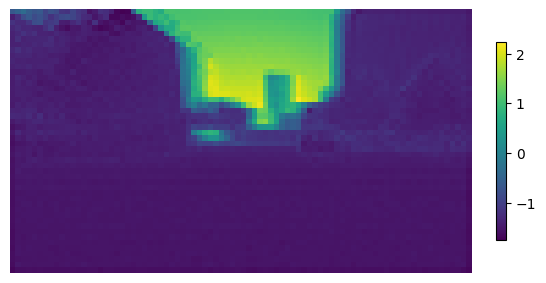

In [35]:
plt.imshow(
    latents_dict_depths['gt_video_latents'][0,4,0].cpu().float(),
    cmap='viridis',
    
)
plt.axis('off')
plt.colorbar(fraction=0.02)

## Run Inference

In [ ]:
generator = torch.Generator(device=opts.device).manual_seed(opts.seed)

with torch.no_grad():
    output_depths = run_inference_from_cached_latents(
        trajcrafter.pipeline,
        latents_dict_depths,
        height=opts.sample_size[0],
        width=opts.sample_size[1],
        num_frames=opts.video_length,
        guidance_scale=opts.diffusion_guidance_scale,
        num_inference_steps=opts.diffusion_inference_steps,
        generator=generator,
        device=torch.device("cuda")
    )

In [ ]:
output_depths.shape

In [ ]:
output_depths_colored.shape

In [ ]:
output_depths_unnorm = torch.from_numpy(output_depths)

# take mean along 1th axis
output_depths_unnorm = output_depths_unnorm.mean(dim=1, keepdim=True)

print(output_depths_unnorm.min(), output_depths_unnorm.max(), output_depths_unnorm.shape)

# # unnormalize depths back to original range
output_depths_unnorm = output_depths_unnorm * (depths_max - depths_min + 1e-8) + depths_min

print(output_depths_unnorm.min(), output_depths_unnorm.max(), output_depths_unnorm.shape)


output_depths_colored = apply_colormap_to_depth(
    output_depths_unnorm[0].squeeze(1),
    inverse=True
    )

print(output_depths_colored.min(), output_depths_colored.max(), output_depths_colored.shape)


save_video(
    output_depths_colored[0],
    f'{save_dir}/gen_depth.mp4',
    fps=10,
)

## Point Cloud Warper

In [ ]:
import sys
sys.path.append('/home/azhuravl/work/TrajectoryCrafter/notebooks/06_10_25_vggt')

import warper_point_cloud
warper = warper_point_cloud.GlobalPointCloudWarper(device='cuda')


In [ ]:
from tqdm import tqdm

pc_list = []
color_list = []

with torch.no_grad():
    for j in tqdm(range(frames_tensor.shape[0])):
        i = 0
        points, colors, _ = warper.create_pointcloud_from_image(
            frames_tensor[i:i+1],
            None,
            depths[i:i+1],
            # torch.inverse(poses_tensor[i:i+1]).to('cuda'),
            poses_tensor[i:i+1].to('cuda'),
            # K_tensor[i:i+1],
            K_tensor.unsqueeze(0),
            1,
        )
        pc_list.append(points)
        color_list.append(colors)

In [ ]:
import utils_autoregressive as utils_ar

warped_images = []
masks = []        

for i in tqdm(range(frames_tensor.shape[0])):

    # warped_image, mask = warper.render_pointcloud_zbuffer_vectorized_point_size(
    warped_image, mask = warper.render_pointcloud_zbuffer_vectorized_fixed(
        pc_list[i],
        color_list[i],
        poses_tensor[i:i+1].to('cuda'),
        K_tensor.unsqueeze(0).to('cuda'),
        image_size=frames_tensor.shape[-2:],
        point_size=2,
    )

    
    cleaned_mask = utils_ar.clean_single_mask_simple(
        mask[0],
        kernel_size=9,
        n_erosion_steps=1,
        n_dilation_steps=1
        )
    # should stay in [-1, 1] range
    
    cleaned_mask = cleaned_mask.unsqueeze(0)
    warped_image = warped_image * cleaned_mask
    
    warped_images.append(warped_image)
    masks.append(cleaned_mask)


In [ ]:
import matplotlib.pyplot as plt

import numpy as np

# plot warped image j, mask j, warped depth j
j = 0
k = 30

frame = frames_tensor[j].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
warped_image = warped_images[k][0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
target_frame = frames_tensor[k].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(frame)
plt.title('Source Frame')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(warped_image)
plt.title('Warped Image to Frame {}'.format(j))
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(target_frame)
plt.title('Target Frame {}'.format(j))
plt.axis('off')


In [ ]:
from models.utils import save_video
import os
import torch

def make_dimensions_even(tensor):
    """Pad tensor to make height and width even numbers"""
    _, h, w, c = tensor.shape
    pad_h = h % 2
    pad_w = w % 2
    
    if pad_h > 0 or pad_w > 0:
        # Pad bottom and right if needed
        tensor = torch.nn.functional.pad(tensor, (0, 0, 0, pad_w, 0, pad_h))
    
    return tensor


cond_video = (torch.cat(warped_images) + 1.0) / 2.0  # [T, 3, H, W] in [0,1]
cond_video_padded = make_dimensions_even(
    cond_video.permute(0, 2, 3, 1)
)
save_dir = '/home/azhuravl/work/TrajectoryCrafter/notebooks/22_10_25_scaling_up/vkitti2_pc_warper'
os.makedirs(save_dir, exist_ok=True)

save_video(
    cond_video_padded,
    f'{save_dir}/warped_video.mp4',
    fps=10,
)
# --- save inputs for visualization ---

input_video_padded = make_dimensions_even(
    (frames_tensor.permute(0, 2, 3, 1) + 1.0) / 2.0
)

save_video(
    input_video_padded,
    f'{save_dir}/input_video.mp4',
    fps=10,
)

warped_depths_tensor = torch.cat(warped_depths)
# Apply before saving
warped_depths_padded = make_dimensions_even(
    (warped_depths_tensor.permute(0, 2, 3, 1).repeat(1, 1, 1, 3)) / warped_depths_tensor.max()
)
save_video(
    warped_depths_padded,
    f'{save_dir}/warped_depths.mp4',
    fps=10,
)

depths_padded = make_dimensions_even(
    (depths.permute(0, 2, 3, 1).repeat(1, 1, 1, 3)) / depths.max()
)
save_video(
    depths_padded,
    f'{save_dir}/input_depths.mp4',
    fps=10,
)

## Viser

In [ ]:
import viser
import numpy as np

# Start viser server
server = viser.ViserServer()
import os

# print slurm node name

node_name=os.environ.get('SLURM_NODELIST', 'localhost')

print(f'http://{node_name}:{server.get_port()}')


def add_points(
    server,
    points: np.ndarray,  # (N, 3)
    colors: np.ndarray,  # (N, 3)
    name: str,
):
    # ensure colors are in [0, 1]
    if colors.min() < -0.1:
        colors = (colors + 1.0) / 2.0
    
    server.scene.add_point_cloud(
        name=name,
        points=points,
        colors=colors,
        point_size=0.01
    )

def add_camera(
    server,
    pose: np.ndarray,  # (4, 4)
    name: str,
    color: tuple = (0.2, 0.8, 0.2),
):
    pose = np.linalg.inv(pose)
    
    position = pose[:3, 3]
    rotation_matrix = pose[:3, :3]
    
    # Convert rotation to quaternion
    wxyz = viser.transforms.SO3.from_matrix(rotation_matrix).wxyz
    
    server.scene.add_camera_frustum(
        name,
        fov=60, aspect=4/3, scale=0.1,
        position=position, wxyz=wxyz,
        color=color
    )
    
# Add this after creating your server and adding point clouds
@server.on_client_connect
def _(client: viser.ClientHandle) -> None:
    yaw_slider = client.gui.add_slider("Camera Yaw", min=-180, max=180, step=1, initial_value=0)
    
    @yaw_slider.on_update
    def _(_):
        angle_rad = np.deg2rad(yaw_slider.value)
        radius = 8.0
        
        position = np.array([
            radius * np.sin(angle_rad),
            0,  # height
            radius * np.cos(angle_rad)
        ])
        
        client.camera.position = position
        client.camera.look_at = np.array([0, 0, 0])
        client.camera.up_direction = np.array([0, -1, 0])


In [ ]:
poses_tensor

In [ ]:
pc_list[0].shape

In [ ]:
server.scene.reset()

# add original point cloud #0, and all cameras from first segment

j_list = [10]

for j in j_list:    
    add_points(
        server,
        pc_list[j].cpu().numpy()[::10,:],
        color_list[j].cpu().numpy()[::10,:],
        name=f'input_pc_{j}'
    )
    
for j in range(frames_tensor.shape[0]):
    add_camera(
        server,
        torch.inverse(poses_tensor[j]).cpu().numpy(),
        name=f'input_cam_{j:02d}',
        color=(0.2, 0.8, 0.2)
    )
   

In [ ]:
depths.min(), depths.max()

In [ ]:
pc_list[10]

In [11]:
sys.path.append('/home/azhuravl/work/TrajectoryCrafter/notebooks/06_10_25_vggt')
from parsing import get_parser
import utils_autoregressive as utils_ar
from datetime import datetime
import os
import copy


sys.argv = [
    "",
    "--video_path", "/home/azhuravl/nobackup/DAVIS_testing/trainval/vkitti2.mp4",
    "--n_splits", "4",
    "--overlap_frames", "0",
    "--radius", "0",
    "--mode", "gradual",
]

parser = get_parser()
opts_base = parser.parse_args()

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
video_basename = os.path.splitext(os.path.basename(opts_base.video_path))[0]

# Setup
opts_base.weight_dtype = torch.bfloat16
opts_base.exp_name = f"{video_basename}_{timestamp}_autoregressive"
opts_base.save_dir = os.path.join(opts_base.out_dir, opts_base.exp_name)

# Create TrajCrafterVisualization instance for autoregressive generation
radius = opts_base.radius

variants = [
    ("right_90", [0, 90, radius, 0, 0]),
]

pose = [90, 0, 0, 0, 1]
name = f"{pose[0]}_{pose[1]}_{pose[2]}_{pose[3]}_{pose[4]}"

opts = copy.deepcopy(opts_base)
opts.exp_name = f"{video_basename}_{timestamp}_{name}_auto_s{opts_base.n_splits}"
opts.save_dir = os.path.join(opts.out_dir, opts.exp_name)
opts.camera = "target"
opts.target_pose = pose
opts.traj_txt = 'test/trajs/loop2.txt'

# Make directories
os.makedirs(opts.save_dir, exist_ok=True)

In [12]:
trajcrafter = utils_ar.TrajCrafterAutoregressive(opts)

Expected types for unet: ['UNetSpatioTemporalConditionModel'], got DiffusersUNetSpatioTemporalConditionModelDepthCrafter.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/diffusers/models/embeddings.py:186: FutureWarning: `get_3d_sincos_pos_embed` uses `torch` and supports `device`. `from_numpy` is no longer required.  Pass `output_type='pt' to use the new version now.
  deprecate("output_type=='np'", "0.33.0", deprecation_message, standard_warn=False)
/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/diffusers/models/embeddings.py:304: FutureWarning: `get_2d_sincos_pos_embed_from_grid` uses `torch` and supports `device`. `from_numpy` is no longer required.  Pass `output_type='pt' to use the new version now.
  deprecate("output_type=='np'", "0.33.0", deprecation_message, standard_warn=False)
/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/diffusers/models/embeddings.py:337: FutureWarning: `get_1d_sincos_pos_embed_from_grid` uses `torch` and supports `device`. `from_numpy` is no longer required.  Pass `output_type=

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
import numpy as np

# frames_tensor = (
    # torch.from_numpy(frames_np).permute(0, 3, 1, 2).to(opts.device) * 2.0 - 1.0
  # 49 576 1024 3 -> 49 3 576 1024, [-1,1]
# reverse this to get frames in numpy
frames_np = ((frames_tensor.cpu().permute(0, 2, 3, 1).numpy() + 1.0) / 2.0).astype(np.float32)

trajcrafter.prompt = trajcrafter.get_caption(opts, frames_np[opts.video_length // 2])
print(trajcrafter.prompt)

In [ ]:
_, segment_dir = utils_ar.sample_diffusion(
    trajcrafter,
    frames_tensor[10:],
    warped_images,
    frames_tensor[:10],
    masks,
    opts,
)

## TartanAir

In [ ]:
import importlib
importlib.reload(video_datasets)

In [ ]:
train_sequences = [
    'abandonedfactory/Easy/P001',
    # 'abandonedfactory/Easy/P005', 
    # 'office/Easy/P001',
    # 'office/Easy/P002',
    # 'office2/Easy/P001'
]

dataset_tartanair = video_datasets.TartanAirDataset(
        aug_params=None,
        root="/home/azhuravl/scratch/tartanair",
        split="train",
        sample_len=59,
        only_first_n_samples=-1,
        sampling_stride=3,          # Starting frame stride (default 3)
        min_temporal_step=1,        # Minimum temporal step (default 1)  
        max_temporal_step=2,        # Maximum temporal step (default 6)
        train_sequences=train_sequences
    )

In [ ]:
data_0 = dataset_tartanair[10]

In [ ]:
data_0

In [ ]:
data_0 = dataset_tartanair[0]
data_1 = dataset_tartanair[1]


In [ ]:
# TODO: fix TartanAir cameras